In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.ion()

# other imports
import logomaker
import glob
import re

In [7]:
# Load in entropies
entropy_df = pd.read_csv('bnb/reads_by_sample.txt', delim_whitespace=True)
entropy_df.set_index('sample', inplace=True, drop=True)
entropy_df

,ct,frac,bits,diversity
sample,,,,
exp3_ars416_mix_plate_m1,301671,0.0077,13.0328,8380.6575
exp3_ars416_mix_plate_m21,284401,0.0072,13.0111,8255.4059
exp3_ars416_mix_plate_m22,223456,0.0057,15.5096,46649.7047
exp3_ars416_mix_plate_m23,276362,0.0070,12.2863,4995.1476
exp3_ars416_mix_plate_m3,198379,0.0051,11.9377,3922.9275
...,...,...,...,...
exp9_ars416_lib_sat1_m22c4,450216,0.0115,6.2757,77.4776
exp9_ars416_lib_sat1_m3c1,473428,0.0121,11.5615,3022.4810
exp9_ars416_lib_sat1_m3c2,546357,0.0139,11.4542,2805.7959


In [3]:
# load metadata
metadata_df = pd.read_excel('bnb/metadata.xlsx', 
                            skiprows=2, 
                            header=0, 
                            sheet_name='mpathic')

# Keep only relevant columns
metadata_df.set_index('name', inplace=True, drop=True)
metadata = metadata_df['ct_1']
metadata_df.head()

,use,learning_method,reps,rc,start_pos,stop_pos,num_steps,ct_0,ct_1,ct_2,ct_3,ct_4
name,,,,,,,,,,,,
exp3_ars416_wt,False,ER,1,True,0,50,25000,exp1_ars416_lib_ref,exp3_ars416_mix_sat1_wt,NaN,NaN,NaN
exp3_ars416_m1,False,ER,1,True,0,50,25000,exp1_ars416_lib_ref,exp3_ars416_mix_sat1_m1,NaN,NaN,NaN
exp3_ars416_m3,False,ER,1,True,0,50,25000,exp1_ars416_lib_ref,exp3_ars416_mix_sat1_m3,NaN,NaN,NaN
exp3_ars416_m5,False,ER,1,True,0,50,25000,exp1_ars416_lib_ref,exp3_ars416_mix_sat1_m5,NaN,NaN,NaN
exp3_ars416_m9,False,ER,1,True,0,50,25000,exp1_ars416_lib_ref,exp3_ars416_mix_sat1_m9,NaN,NaN,NaN


In [4]:
# Load dataframe with all matrices
data_df = pd.read_csv('data.txt', delimiter='\t', index_col=0)
print('data_df has %d rows.'%len(data_df))

# Set data_cols and info_cols
data_cols = [c for c in data_df.columns if '.' in c]
info_cols = [c for c in data_df.columns if '.' not in c]
L = int(len(data_cols)/4)

# Just to be super sure, fix the gauge of each matrix in each row
print('Fixing gauges just to be sure')
for i, row in data_df.iterrows():
    vec = row[data_cols].values
    mat = vec.reshape(L,4)
    mat = mat - mat.mean(axis=1)[:,np.newaxis]
    mat /= (mat**2).sum()
    row[data_cols] = mat.ravel()
    print('.', end='')
print('\nDone.')

# Restrict strains to look at
strain_list = [
 'WT',
 'FY-YF',
 'F485I',
 'Y486Q',
 'FY-IQ',
 'FY-AA',
 'N489A',
 'N489W',
 'R478A',
 'R478K']

# Set ars indices
ix_ars416 = data_df['ars'].str.match('ars416')\
            & data_df['mut'].isin(strain_list) \
            #& data_df['exp'].isin(['exp4','exp7','exp9']) 

ix_ars317 = data_df['ars'].str.match('ars317')\
            & data_df['mut'].isin(strain_list) \
            #& data_df['exp'].isin(['exp5','exp6','exp7']) \
            #& ~((data_df['exp']=='exp5') & data_df['mut'].str.match('FY-IQ')) # This sample is bad
            
# Restrict rows and cols
ix = (ix_ars416 | ix_ars317) & data_df['lm'].str.match('IM')
data_df = data_df.loc[ix,info_cols]

# Remove IM fro names
data_df.index = [name[:-3] for name in data_df.index]

# Fix m3 in 'strain' and index
ix = data_df['strain'].str.match('^m2$')
data_df.loc[ix,'strain'] = 'm3'
new_names = ['%s_%s_%s'%(r['exp'], r['ars'], r['strain']) for i,r in data_df.iterrows()]
new_names.sort()
assert len(new_names)==len(set(new_names)), 'new_names entries are not unique!'
data_df['name'] = new_names
data_df.set_index('name', inplace=True, drop=True)

# Add in ct_1_samples
data_df['ct_1_sample'] = [metadata[name] for name in data_df.index]
assert len(set(data_df['ct_1_sample']))==len(data_df['ct_1_sample']), 'ct_1_samples are not unique!'
data_df.head()

# Look up entropies
data_df['entropy'] = [entropy_df.loc[name,'bits'] for name in data_df['ct_1_sample']]

# Show results
print('processed data_df has %d rows'%len(data_df))
data_df.head()

data_df has 120 rows.
Fixing gauges just to be sure
........................................................................................................................
Done.
processed data_df has 60 rows


,lm,ars,mut,strain,exp,ct_1_sample,entropy
name,,,,,,,
exp4_ars416_m1,IM,ars317,F485I,m3,exp6,exp4_ars416_lib_sat_m1,9.7755
exp4_ars416_m20,IM,ars317,F485I,m3,exp7,exp4_ars416_lib_sat_m20,10.3155
exp4_ars416_m21,IM,ars317,FY-AA,m21,exp6,exp4_ars416_lib_sat_m21,8.5943
exp4_ars416_m22,IM,ars317,FY-AA,m21,exp7,exp4_ars416_lib_sat_m22,5.2683
exp4_ars416_m23,IM,ars317,FY-IQ,m22,exp5,exp4_ars416_lib_sat_m23,9.9073


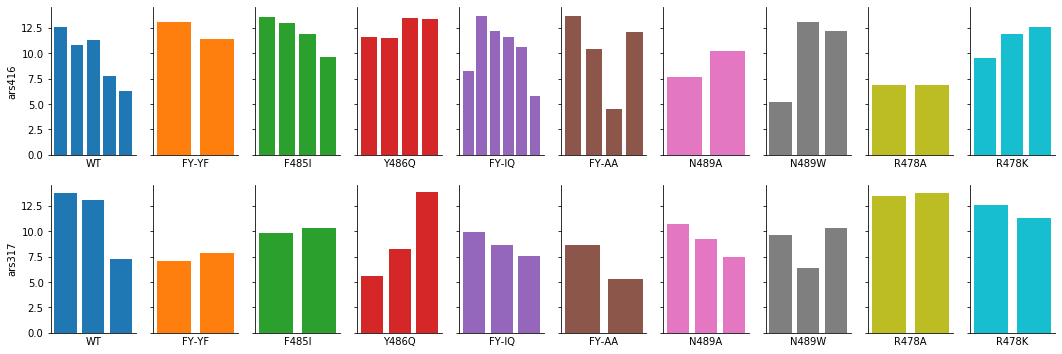

In [5]:
arss = ['ars416', 'ars317']

num_cols = len(strain_list)
num_rows = len(arss)
fig, axs = plt.subplots(num_rows, num_cols, figsize=[18,6], sharey=True)

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Asign each strain a color
strain_to_color_dict = dict([(s, colors[n]) for n,s in enumerate(strain_list)])

for row_num, ars in enumerate(arss):
    
    for col_num, strain in enumerate(strain_list):
        ix = (data_df['ars']==ars) & (data_df['mut']==strain)
        ax = axs[row_num,col_num]
        tmp_df = data_df[ix].copy()
        tmp_df.reset_index(inplace=True, drop=False)
        
        ys = tmp_df['entropy']
        xs = tmp_df.index
        color = strain_to_color_dict[strain]
        ax.bar(x=xs, height=ys, color=color)
        ax.set_xticks([])
        ax.set_xlabel(strain)
        sns.despine()
        if col_num==0:
            ax.set_ylabel(ars)
        else:
            ax.set_ylabel('')

In [ ]:
arss = ['ars416', 'ars317']

num_cols = len(strain_list)
num_rows = len(arss)
fig, axs = plt.subplots(num_rows, 1, figsize=[18,6], sharey=True)

# Get default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Asign each strain a color
strain_to_color_dict = dict([(s, colors[n]) for n,s in enumerate(strain_list)])

for row_num, ars in enumerate(arss):
    xmin = 0
    xticks = []
    xticklabels = []
    ax = axs[row_num]
    for col_num, strain in enumerate(strain_list):
        ix = (data_df['ars']==ars) & (data_df['mut']==strain)
        tmp_df = data_df[ix].copy()
        tmp_df.reset_index(inplace=True, drop=False)
        
        xmax = xmin+len(tmp_df)
        xtick = .5*xmin+.5*xmax-.5
        xticks.append(xtick)
        xticklabels.append(strain)
        
        ys = tmp_df['entropy']
        xs = xmin + tmp_df.index
        xmin += len(tmp_df)
        color = strain_to_color_dict[strain]
        ax.bar(x=xs, height=ys, color=color)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)